In [19]:
import fastmri
from fastmri.data import transforms as T
import h5py
import numpy as np
from matplotlib import pyplot as plt

from utils_torch import virtual_coil_reconstruction, show_coils

In [20]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
hf = h5py.File(file_path)

In [21]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(7, 12, 128, 64)


In [22]:
slice_kspace = volume_kspace[volume_kspace.shape[0]-1] # Choosing the lastest slice of this volume
# print(slice_kspace)

In [23]:
num_coils = slice_kspace.shape[0] # number of coils in the k-space
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
print(slice_kspace2.shape)
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
print(slice_image.shape)
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
print(slice_image_abs.shape)

# for coil_index in range(num_coils):
#     show_coils(np.log(np.abs(slice_kspace) + 1e-9), [coil_index])
#     show_coils(slice_image_abs, [coil_index], cmap='gray')

torch.Size([12, 128, 64, 2])
torch.Size([12, 128, 64, 2])
torch.Size([12, 128, 64])


torch.Size([128, 64])


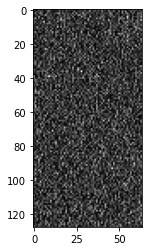

In [24]:
new_image_singlecoil = virtual_coil_reconstruction(slice_image_abs)
print(new_image_singlecoil.shape)
plt.imshow(np.abs(new_image_singlecoil.numpy()), cmap='gray')